In [2]:
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification, ViTConfig
from PIL import Image
import requests

In [3]:
import os
import re
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# pytorch related imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms

from torchmetrics.functional import fbeta

# lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint


import sys
sys.path.append("./ViT-pytorch/")
from models.modeling import VisionTransformer, CONFIGS


# Creating Dataset class

In [13]:
class firesmoke_image_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file_path, class_list, image_dir, filename_col_name='image_name', transform=None):
        self.filename = filename_col_name
        self.class_list = class_list
        self.class_list.sort()
        self.data_frame = pd.read_csv(csv_file_path)
        self.image_dir = image_dir
        self.transform = transform
        self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        
    def __len__(self):
        return len(self.data_frame)
        pass
    
    def __getitem__(self, index):
        
        row = self.data_frame.iloc[index]
        image_path = self.image_dir+"/"+row[self.filename].strip()
        
        img = cv2.imread(image_path)
        if img is None:
            print(f"no image found @ {image_path}")
            img = np.zeros((224,224, 3))
       
        if self.transform:
            img = self.transform(img)
            
        #img = np.einsum("ijk->kij", img)
        img = self.feature_extractor(img)['pixel_values'][0] # Don't forget this to apply while inference
        #img = image = Image.open(image_path)
        
        labels = []
        for cls in self.class_list:
            labels.append(int(row[cls]))#.to_numpy(dtype=np.float32)
        labels = np.array(labels)
        
        
            
        return [img, labels]

## test

In [21]:
if __name__ == "__main__":
    transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.CenterCrop((100, 100)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor()
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
    
    dataset = firesmoke_image_dataset(csv_file_path="./raw_data/fire&safety&smoke_processed.csv",
                                      class_list=['fire', 'spark', 'smoke'],
                                      image_dir="../fnS_images/",
                                      filename_col_name="Filename",
                                     transform=transform)
    dl = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=12)

    b = None
    for batch in dl:
        b = batch
        break

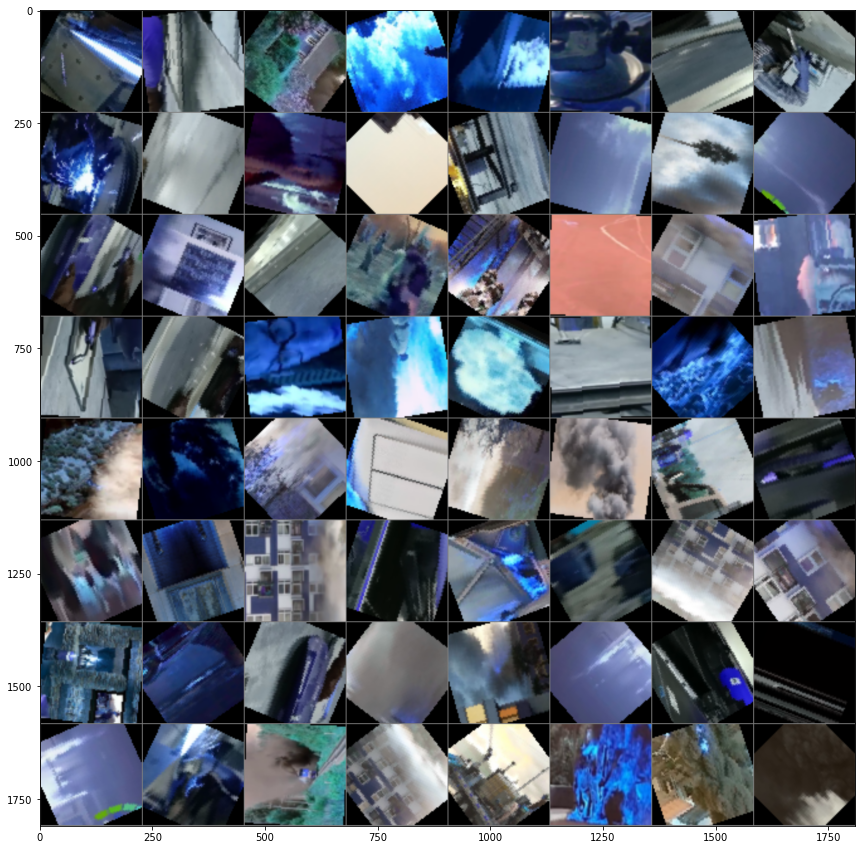

In [22]:
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if __name__=="__main__":
    data = iter(dl)
    images = data.next()
    show_img(torchvision.utils.make_grid(images[0]))

## creating pl datamodule

In [ ]:
class FireSmokeDataModule(pl.LightningDataModule):
    def __init__(self, csv_file_path, 
                 class_list, 
                 image_dir, 
                 filename_col_name='image_name', 
                 transform=None,
                 batch_size=5):
        
        super().__init__()
        self.csv_file_path = csv_file_path
        self.image_dir = image_dir
        self.class_list = class_list
        self.filename_col_name = filename_col_name
        self.transform = transform
        self.batch_size = batch_size

#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])
        
#         self.dims = (3, 32, 32)
#         self.num_classes = 10

    def prepare_data(self):
        # download 
        pass

    def setup(self, stage=None):
        self.firesmoke_ds_train = firesmoke_image_dataset(
            csv_file_path=self.csv_file_path,
            class_list=self.class_list,
            image_dir=self.image_dir,
            filename_col_name=self.filename_col_name,
            transform=self.transform
        )
        self.firesmoke_ds_val = firesmoke_image_dataset(
            csv_file_path=self.csv_file_path.replace("_train","_val"),
            class_list=self.class_list,
            image_dir=self.image_dir,
            filename_col_name=self.filename_col_name,
            
        )
        self.firesmoke_ds_test = firesmoke_image_dataset(
            csv_file_path=self.csv_file_path.replace("_train", "_test"),
            class_list=self.class_list,
            image_dir=self.image_dir,
            filename_col_name=self.filename_col_name,
            
        )
            

    def train_dataloader(self):
        return DataLoader(self.firesmoke_ds_train, batch_size=self.batch_size, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.firesmoke_ds_val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.firesmoke_ds_test, batch_size=self.batch_size, num_workers=12)

# Creating pl lightningModule for vision transformer

In [4]:
class ViTfinetune(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=2e-4):
        super().__init__()
        self.num_classes = num_classes
        self.save_hyperparameters()
        pooler_dims = 768
        
        config = CONFIGS["ViT-B_16"]
        model = VisionTransformer(config, num_classes=3, zero_head=True, img_size=224, vis=True)
        model.load_from(np.load("ViT-B_16.npz"))
        self.vit_model = model
        
        
        self.learning_rate = learning_rate
        self.BCE_logit_loss = nn.BCEWithLogitsLoss()
    # will be used during inference
    def forward(self, x, prob=False):
        
        x, att = self.vit_model(x)
        
        if prob:
            x = F.sigmoid(x, dim=1)
        
        #x = F.log_softmax(x, dim=1)
        return x

    # logic for a single training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
       
        loss = self.BCE_logit_loss(logits, y.float())
        
        # training metrics
        preds = logits#torch.argmax(logits, dim=1)
        acc = fbeta(preds, y, num_classes=self.num_classes, beta=0.5)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss

    # logic for a single validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
#         print(y)
#         global tmp_global 
#         tmp_global= (logits, y)
        loss = self.BCE_logit_loss(logits, y.float())

        # validation metrics
        preds = logits#torch.argmax(logits, dim=1)
        acc = fbeta(preds, y, num_classes=self.num_classes, beta=0.5)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    # logic for a single testing step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.BCE_logit_loss(logits, y.float())
        
        # validation metrics
        preds = logits #torch.argmax(logits, dim=1)
        acc = fbeta(preds, y, num_classes=self.num_classes, beta=0.5)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [10]:
if __name__ == "__main__":
    ft = ViTfinetune(num_classes=5)
    lsm = ft(b[0])
    torch.argmax(lsm , dim=1)
    lsm

# Creating callbacks

In [11]:
if __name__ == "__main__":
    early_stop_callback = EarlyStopping(
       monitor='val_loss',
       patience=3,
       verbose=False,
       mode='min'
    )

    MODEL_CKPT_PATH = 'model/'
    MODEL_CKPT = 'model-{epoch:02d}-{val_loss:.2f}'

    checkpoint_callback = ModelCheckpoint(
        dirpath=MODEL_CKPT_PATH,
        monitor='val_loss',
        filename=MODEL_CKPT ,
        save_top_k=3,
        mode='min')

/abhishek/anish/miniconda3/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory model/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


# Lightning Trainer 

In [ ]:
if __name__ == "__main__":
    CSV_FILE="./raw_data/fire&safety&smoke_processed_train.csv"
    IMAGE_DIR = "../fnS_images/"
    # Init our data pipeline
    dm = FireSmokeDataModule(
        csv_file_path=CSV_FILE,
        class_list=['fire', 'spark', 'smoke'],
        image_dir=IMAGE_DIR,
        filename_col_name="Filename",
        batch_size=20

    )
    # To access the x_dataloader we need to call prepare_data and setup.
    dm.prepare_data()
    dm.setup()

    # Samples required by the custom ImagePredictionLogger callback to log image predictions.
    val_samples = next(iter(dm.val_dataloader()))
    val_imgs, val_labels = val_samples[0], val_samples[1]
    val_imgs.shape, val_labels.shape





In [13]:
if __name__ == "__main__":
    # Init our model
    model = ViTfinetune(num_classes=3)
    tb_logger = TensorBoardLogger("logs/")

    # Initialize a trainer
    trainer = pl.Trainer(max_epochs=50,
                         progress_bar_refresh_rate=20, 
                         gpus=1, 
                         logger=tb_logger,
                         callbacks=[early_stop_callback, checkpoint_callback])

    # Train the model ⚡🚅⚡
    trainer.fit(model, dm)

    # Evaluate the model on the held-out test set ⚡⚡
    trainer.test()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/abhishek/anish/miniconda3/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: 

In [14]:
def load_model(checkpoint_file_path=None):
    model = ViTfinetune.load_from_checkpoint(checkpoint_file_path)
    #model.load_from_checkpoint(checkpoint_file_path)
    return model
    pass

In [15]:
if __name__ == "__main__":
    model = load_model("~/ViT_clf/model/model-epoch=47-val_loss=0.00-v2.ckpt")

FileNotFoundError: [Errno 2] No such file or directory: '/abhishek/anish/ViT_clf/model/model-epoch=47-val_loss=0.00-v2.ckpt'

In [16]:
def inference(model, image: np.array, transformer_feature_extractor, class_list):
    result = []
    model_input = transformer_feature_extractor(image, return_tensors='pt')['pixel_values']
    log_prob = model(model_input)
    prob=torch.exp(op)
    for each_img_in_batch in range(prob.shape[0]):
        tmp_prob = prob[each_img_in_batch].tolist()
        tmp_out_dict = dict(zip(class_list, tmp_prob))
        result.append(tmp_out_dict)
    return result
        
        
    
    
    pass
    

## Inference 

In [17]:
if __name__ == "__main__":
    image_path = "./raw_data/images/airplane_00001.jpg"
    img = cv2.imread(image_path)
    ip = [img, img, img]
    feature_extractor  = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [18]:
if __name__ == "__main__":
    inference(model, ip, feature_extractor, ['a', 'b', 'c', 'd'])

NameError: name 'op' is not defined